# Working Example
## Multi-variate, Multi-step Time Series Prediction w/ LSTM

Import Modules

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import tqdm
%matplotlib inline

Load Data

In [108]:
if True:
    keep_col = list(range(1,18))

    df_day = pd.read_csv('Clean Data/ECL_Clean_Day.csv', 
                         infer_datetime_format=True,
                         parse_dates=['Timestamp'], 
                         index_col=['Timestamp'],
                         usecols = keep_col,
                         date_parser=lambda col: pd.to_datetime(col, utc=True).tz_convert('America/New_York'))

    #df_day.dtypes
    print (df_day.shape,'\n')
    print (df_day.head(3))

(5031, 16) 

                             Open    High     Low   Close   Volume  SMA_10  \
Timestamp                                                                    
2000-01-03 00:00:00-05:00  19.500  19.500  18.750  18.813   580000     NaN   
2000-01-04 00:00:00-05:00  18.813  18.969   9.000   9.188  1528798     NaN   
2000-01-05 00:00:00-05:00   9.250  19.188   9.188  19.063   700200     NaN   

                           SMA_50  EMA_10  EMA_50         RSI  ROC  MACD_Line  \
Timestamp                                                                       
2000-01-03 00:00:00-05:00     NaN     NaN     NaN  100.000000  NaN        NaN   
2000-01-04 00:00:00-05:00     NaN     NaN     NaN    0.000000  NaN        NaN   
2000-01-05 00:00:00-05:00     NaN     NaN     NaN   52.491694  NaN        NaN   

                           MACD_Diff  MACD_Sig  WO  ATR  
Timestamp                                                
2000-01-03 00:00:00-05:00        NaN       NaN NaN  0.0  
2000-01-04 00:00

Slice the data to get the 10 most recent years (2010 through 2019)

In [109]:
# create 10 years of data from 2019 - 2010

day_data = df_day[df_day.index >= '2010-01-01']
day_data.shape

(2516, 16)

Slice the data for the first 5 columns (Open, High, Low, Close, Volume) and then rearrange with Close price as the last column.

In [110]:
#slice for the first 4 cols only
data = day_data.loc[:,'Open':'Close']

#rearrange column order
data = data[['Open', 'High', 'Low', 'Close']]
print (data.shape)
data.head(3)

(2516, 4)


,Open,High,Low,Close
Timestamp,,,,
2010-01-04 00:00:00-05:00,45.08,45.3392,44.86,45.23
2010-01-05 00:00:00-05:00,45.12,45.1400,44.31,44.51
2010-01-06 00:00:00-05:00,44.49,44.8500,44.15,44.41


Function borrowed from Jason Brownlee's amazing website: [www.machinelearningmastery.com]

In [111]:
#from: machinelearningmastery.com/blog/

def time_series_to_supervised(data, n_lag=1, n_fut=1, selLag=None, selFut=None, dropnan=True):
    """
    Converts a time series to a supervised learning data set by adding time-shifted prior and future period
    data as input or output (i.e., target result) columns for each period
    :param data:  a series of periodic attributes as a list or NumPy array
    :param n_lag: number of PRIOR periods to lag as input (X); generates: Xa(t-1), Xa(t-2); min= 0 --> nothing lagged
    :param n_fut: number of FUTURE periods to add as target output (y); generates Yout(t+1); min= 0 --> no future periods
    :param selLag:  only copy these specific PRIOR period attributes; default= None; EX: ['Xa', 'Xb' ]
    :param selFut:  only copy these specific FUTURE period attributes; default= None; EX: ['rslt', 'xx']
    :param dropnan: True= drop rows with NaN values; default= True
    :return: a Pandas DataFrame of time series data organized for supervised learning
    NOTES:
    (1) The current period's data is always included in the output.
    (2) A suffix is added to the original column names to indicate a relative time reference: e.g., (t) is the current
        period; (t-2) is from two periods in the past; (t+1) is from the next period
    (3) This is an extension of Jason Brownlee's series_to_supervised() function, customized for MFI use
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    origNames = df.columns
    cols, names = list(), list()
    # include all current period attributes
    cols.append(df.shift(0))
    names += [('%s' % origNames[j]) for j in range(n_vars)]
 
    # lag any past period attributes (t-n_lag,...,t-1)
    n_lag = max(0, n_lag)  # force valid number of lag periods
    for i in range(n_lag, 0, -1):
        suffix= '(t-%d)' % i
        if (None == selLag):   # copy all attributes from PRIOR periods?
            cols.append(df.shift(i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:
            for var in (selLag):
                cols.append(df[var].shift(i))
                names+= [('%s%s' % (var, suffix))]
 
    # include future period attributes (t+1,...,t+n_fut)
    n_fut = max(n_fut, 0)  # force valid number of future periods to shift back
    for i in range(1, n_fut + 1):
        suffix= '(t+%d)' % i
        if (None == selFut):  # copy all attributes from future periods?
            cols.append(df.shift(-i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:  # copy only selected future attributes
            for var in (selFut):
                cols.append(df[var].shift(-i))
                names += [('%s%s' % (var, suffix))]
    # combine everything
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values introduced by lagging
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Problem Framing:
* Multivariate (Open, High, Low, Close, Volume)
* Univariate, multistep output (Close)
* Predict the next 30 days Close price using the previous 30 days

Therefore:
* n_in = 30
* n_out = 30
* n_features = 4

Rerrange the data to a supervised learning problem using the `time_series_to_supervised` function.

In [112]:
data = time_series_to_supervised(data, n_lag=30, n_fut=30, selFut=['Close'])

As expected, we end up with 30 * 4 + 30 * 1 + 4 = 154 columns. That splits as:
* 30 x 4 = n_in x n_features (in)
* 30 x 4 = n_out x n_features (out)
* 1 x 4 = n_features a time t

In [113]:
data.shape

(2456, 154)

In [114]:
for i in data.columns:
    print (i)

Open
High
Low
Close
Open(t-30)
High(t-30)
Low(t-30)
Close(t-30)
Open(t-29)
High(t-29)
Low(t-29)
Close(t-29)
Open(t-28)
High(t-28)
Low(t-28)
Close(t-28)
Open(t-27)
High(t-27)
Low(t-27)
Close(t-27)
Open(t-26)
High(t-26)
Low(t-26)
Close(t-26)
Open(t-25)
High(t-25)
Low(t-25)
Close(t-25)
Open(t-24)
High(t-24)
Low(t-24)
Close(t-24)
Open(t-23)
High(t-23)
Low(t-23)
Close(t-23)
Open(t-22)
High(t-22)
Low(t-22)
Close(t-22)
Open(t-21)
High(t-21)
Low(t-21)
Close(t-21)
Open(t-20)
High(t-20)
Low(t-20)
Close(t-20)
Open(t-19)
High(t-19)
Low(t-19)
Close(t-19)
Open(t-18)
High(t-18)
Low(t-18)
Close(t-18)
Open(t-17)
High(t-17)
Low(t-17)
Close(t-17)
Open(t-16)
High(t-16)
Low(t-16)
Close(t-16)
Open(t-15)
High(t-15)
Low(t-15)
Close(t-15)
Open(t-14)
High(t-14)
Low(t-14)
Close(t-14)
Open(t-13)
High(t-13)
Low(t-13)
Close(t-13)
Open(t-12)
High(t-12)
Low(t-12)
Close(t-12)
Open(t-11)
High(t-11)
Low(t-11)
Close(t-11)
Open(t-10)
High(t-10)
Low(t-10)
Close(t-10)
Open(t-9)
High(t-9)
Low(t-9)
Close(t-9)
Open(t-8)
High(t

Split the data into train and test based on a date. That gives 7 years for training and 3 years for testing.

In [115]:
cut_off = '2017-01-01'
train = data[data.index < cut_off].values
test = data[data.index > cut_off].values
print (train.shape, test.shape)

(1732, 154) (724, 154)


Reshape the data for LSTM

In [116]:
n_features = 4
n_in, n_out = 30, 30

# 5 features, 3 timesteps lag
n_obs = n_features * n_lag

# split X, y
X_train, y_train = train[:, :n_obs], train[:, -n_out:] #-n_features
X_test, y_test = test[:, :n_obs], test[:, -n_out:] #-n_features
print('Shape of splits:')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape,'\n')

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_lag, n_features))
X_test = X_test.reshape((X_test.shape[0], n_lag, n_features))
print('Re-shaped for LSTM:')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Shape of splits:
(1732, 120) (1732, 30) (724, 120) (724, 30) 

Re-shaped for LSTM:
(1732, 30, 4) (1732, 30) (724, 30, 4) (724, 30)


Define a simple stacked LSTM model and train it

In [117]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [118]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=((X_train.shape[1]), X_train.shape[2])))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_out))
model.compile(optimizer='adam', loss='mae')

In [119]:
history = model.fit(X_train, y_train, 
                    epochs=10, batch_size=30, 
                    validation_data=(X_test, y_test), 
                    verbose=1, shuffle=False)

Train on 1732 samples, validate on 724 samples
Epoch 1/10
1732/1732 [==============================] - 6s 3ms/step - loss: 216.7699 - val_loss: 358.5105
Epoch 2/10
1732/1732 [==============================] - 5s 3ms/step - loss: 183.7046 - val_loss: 137.0431
Epoch 3/10
1732/1732 [==============================] - 4s 2ms/step - loss: 18.6892 - val_loss: 13.6546
Epoch 4/10
1732/1732 [==============================] - 3s 2ms/step - loss: 9.7024 - val_loss: 12.6248
Epoch 5/10
1732/1732 [==============================] - 4s 2ms/step - loss: 7.7372 - val_loss: 9.9092
Epoch 6/10
1732/1732 [==============================] - 4s 2ms/step - loss: 7.2057 - val_loss: 9.7837
Epoch 7/10
1732/1732 [==============================] - 4s 2ms/step - loss: 6.6459 - val_loss: 10.1043
Epoch 8/10
1732/1732 [==============================] - 4s 2ms/step - loss: 6.3018 - val_loss: 9.4164
Epoch 9/10
1732/1732 [==============================] - 4s 2ms/step - loss: 6.1926 - val_loss: 9.1241
Epoch 10/10
1732/1732 [

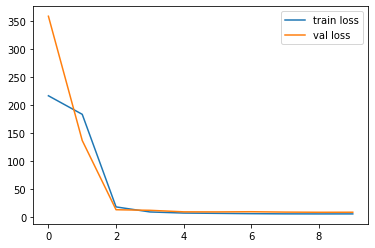

In [120]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

Model performance is poor but that's irrelevant at this stage. I'll grid search this later.

In [121]:
print (X_test[0].shape)
X_test[0]

(30, 4)


array([[117.58  , 118.41  , 117.29  , 118.03  ],
       [114.31  , 114.88  , 114.115 , 114.84  ],
       [114.83  , 115.27  , 114.09  , 114.31  ],
       [114.9   , 115.23  , 114.36  , 114.91  ],
       [115.058 , 116.56  , 114.91  , 116.39  ],
       [116.34  , 117.44  , 116.34  , 116.77  ],
       [116.84  , 116.84  , 116.12  , 116.56  ],
       [116.61  , 117.    , 116.05  , 116.33  ],
       [116.23  , 116.98  , 115.78  , 116.41  ],
       [116.7359, 117.37  , 116.16  , 116.695 ],
       [117.    , 118.55  , 116.88  , 118.49  ],
       [118.457 , 118.72  , 116.41  , 116.81  ],
       [117.32  , 119.05  , 117.    , 118.56  ],
       [118.21  , 118.38  , 116.42  , 116.91  ],
       [116.85  , 118.82  , 116.64  , 118.78  ],
       [118.8158, 119.76  , 118.42  , 119.56  ],
       [119.34  , 120.51  , 119.31  , 120.5   ],
       [120.98  , 121.81  , 120.485 , 121.48  ],
       [121.88  , 122.25  , 121.25  , 122.18  ],
       [121.9947, 122.23  , 120.83  , 121.03  ],
       [120.28  , 12

In [122]:
print (y_test[0].shape)
y_test[0]

(30,)


array([118.79, 118.55, 118.93, 118.85, 117.81, 118.31, 118.65, 118.56,
       118.67, 119.09, 118.83, 118.4 , 119.35, 121.65, 122.49, 120.98,
       121.29, 121.46, 120.16, 120.77, 120.2 , 120.73, 119.68, 120.18,
       120.33, 120.55, 121.11, 121.76, 122.79, 123.39])

In [123]:
# make a prediction

x_input = X_test[0].reshape((1, n_lag, n_features))
yhat = model.predict(x_input)

In [124]:
print (yhat[0].shape)
yhat

(30,)


array([[116.477066, 115.850426, 124.83227 , 124.49792 , 111.05237 ,
        110.91412 , 112.937744, 120.52274 , 106.022316, 120.21299 ,
        121.05868 , 101.66692 , 102.31312 , 124.46247 , 117.820526,
        118.8439  , 113.82962 , 119.00057 , 122.34073 , 114.164795,
        112.640945, 121.70441 , 119.76957 , 108.161026, 118.5379  ,
        118.17746 , 110.20075 , 113.265   , 117.26482 , 115.25251 ]],
      dtype=float32)

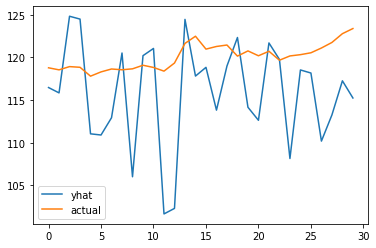

In [125]:
plt.plot(yhat[0], label='yhat')
plt.plot(y_test[0], label='actual')
plt.legend()
plt.show()

In [126]:
rmse = metrics.mean_squared_error(y_test[0], yhat[0])
print ('Root Mean Squared Error:',rmse)

Root Mean Squared Error: 53.211552874901486


# Not Working Example
## Multi-variate, Multi-step Time Series Prediction w/ LSTM using SCALED data
Everything is the same, except I want to standardize the input data using MinMaxScaler as I'm planning to add in a bunch of additional features that are of vastly different magnitudes. <br>I'll start by copying the supervised learning dataframe.

In [127]:
data_test = data.copy()
data_test.shape

(2456, 154)

In [128]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

scaled = scaler.fit_transform(data_test)
print (scaled.shape)

(2456, 154)


In [129]:
n_train = 1732 # splits on dates as above except by index
n_features = 4
n_lag = 30
n_in, n_out = 30, 30

# 5 features, 3 timesteps lag
n_obs = n_features * n_lag

# split X, y
X_train, y_train = scaled[:n_train, :n_obs], scaled[:n_train, -n_out:] #-n_features
X_test, y_test = scaled[n_train:, :n_obs], scaled[n_train:, -n_out:] #-n_features
print('Shape of splits:')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape,'\n')

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_lag, n_features))
X_test = X_test.reshape((X_test.shape[0], n_lag, n_features))
print('Re-shaped for LSTM:')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Shape of splits:
(1732, 120) (1732, 30) (724, 120) (724, 30) 

Re-shaped for LSTM:
(1732, 30, 4) (1732, 30) (724, 30, 4) (724, 30)


Same shape as example above. We'll initialize a new model with the same architecture as above and train it.

In [130]:
model_test = Sequential()
model_test.add(LSTM(100, activation='relu', return_sequences=True, input_shape=((X_train.shape[1]), X_train.shape[2])))
model_test.add(LSTM(100, activation='relu'))
model_test.add(Dense(n_out))
model_test.compile(optimizer='adam', loss='mae')

In [141]:
history_test = model_test.fit(X_train, y_train, 
                    epochs=10, batch_size=30, 
                    validation_data=(X_test, y_test), 
                    verbose=1, shuffle=False)

Train on 1732 samples, validate on 724 samples
Epoch 1/10
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0177 - val_loss: 0.1277
Epoch 2/10
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0176 - val_loss: 0.1313
Epoch 3/10
1732/1732 [==============================] - 3s 2ms/step - loss: 0.0173 - val_loss: 0.1290
Epoch 4/10
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0172 - val_loss: 0.1273
Epoch 5/10
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0175 - val_loss: 0.1266
Epoch 6/10
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0174 - val_loss: 0.1245
Epoch 7/10
1732/1732 [==============================] - 4s 3ms/step - loss: 0.0181 - val_loss: 0.1226
Epoch 8/10
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0193 - val_loss: 0.1212
Epoch 9/10
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0210 - val_loss: 0.1230
Epoch 10/10
1732/1732 [============

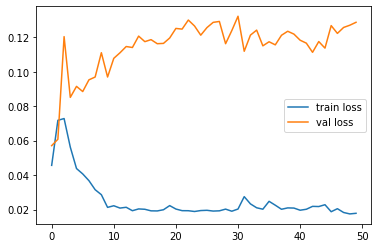

In [132]:
plt.plot(history_test.history['loss'], label='train loss')
plt.plot(history_test.history['val_loss'], label='val loss')
plt.legend()
plt.show()

Model performance is again poor but this isn't relevant now. I'll grid search a better architecture later. I'll first try and make a single prediction from X_test[0]

In [133]:
print (X_test[0].shape)
X_test[0]

(30, 4)


array([[0.45413391, 0.4547839 , 0.46109667, 0.4576718 ],
       [0.43526122, 0.43454968, 0.44311395, 0.43946644],
       [0.43835535, 0.43687124, 0.44296314, 0.43629621],
       [0.43877187, 0.43663313, 0.4445919 , 0.43988515],
       [0.43971201, 0.44455027, 0.44790975, 0.44873789],
       [0.44734024, 0.44978868, 0.45653616, 0.45101089],
       [0.45031536, 0.44621704, 0.45520902, 0.44975476],
       [0.4489468 , 0.44716947, 0.45478675, 0.44837899],
       [0.44668571, 0.44705042, 0.45315799, 0.44885752],
       [0.44969594, 0.44937199, 0.45545032, 0.45056227],
       [0.4512674 , 0.45639621, 0.45979369, 0.4612992 ],
       [0.45993693, 0.45740818, 0.45695844, 0.45125015],
       [0.45317149, 0.45937258, 0.46051758, 0.46171791],
       [0.45846721, 0.45538425, 0.45701876, 0.45184831],
       [0.45037487, 0.45800345, 0.4583459 , 0.46303386],
       [0.46207188, 0.46359902, 0.46908367, 0.46769949],
       [0.465191  , 0.46806358, 0.47445255, 0.47332217],
       [0.47494942, 0.47580213,

In [134]:
print (y_test[0].shape)
y_test[0]

(30,)


array([0.46222515, 0.46078725, 0.46306393, 0.46258463, 0.45517863,
       0.45785521, 0.45989787, 0.45903216, 0.45969342, 0.46102687,
       0.45946044, 0.4568698 , 0.4625933 , 0.4764502 , 0.48151098,
       0.47205643, 0.47252614, 0.47355377, 0.46569546, 0.46938282,
       0.46593725, 0.46914103, 0.46279393, 0.46581636, 0.46672309,
       0.46805295, 0.47022115, 0.4736491 , 0.47910593, 0.48262454])

In [135]:
# make a prediction

x_input = X_test[0].reshape((1, n_lag, n_features))
print (x_input.shape)
yhat = model.predict(x_input)

(1, 30, 4)


In [136]:
print (yhat[0].shape)
yhat

(30,)


array([[-0.00903219,  0.11790405, -0.08642016,  0.00292022,  0.10133739,
         0.06615984,  0.01434928, -0.00076718,  0.06672458, -0.05749612,
         0.00959161,  0.11929265,  0.03426713,  0.0376856 , -0.02973297,
         0.00675971,  0.08313873,  0.03308712,  0.01652435,  0.16677892,
        -0.00106546, -0.06557446, -0.01277334,  0.08809669, -0.02564641,
         0.00607626,  0.08215622,  0.05124085,  0.00919541, -0.06729279]],
      dtype=float32)

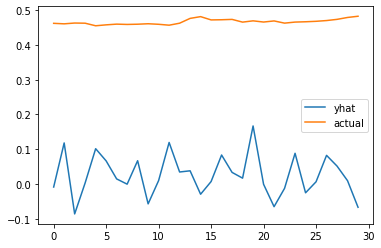

In [137]:
plt.plot(yhat[0], label='yhat')
plt.plot(y_test[0], label='actual')
plt.legend()
plt.show()

OK, we have prediction (albeit, a crap one) but I can't work out how to invert the scaling on either a single input in X_test or by predicting the entire X_test in a single go.

In [138]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat[0], X_test[:0, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

AxisError: axis 1 is out of bounds for array of dimension 1

Trying again for a prediction of everything in X_test (closer to example)

In [139]:
yhat_entire = model_test.predict(X_test)
X_test_entire = X_test.reshape((X_test.shape[0], n_in*n_features))
print (yhat_entire.shape)
print (X_test_entire.shape)

(724, 30)
(724, 120)


Looking at these two shapes, I'm still 4 columns short of the array size that the MinMaxScaler was applied too.

In [140]:
# invert scaling for forecast
#inv_yhat = np.concatenate((yhat_entire, X_test_entire[:, -30:]), axis=1)
inv_yhat = np.concatenate((yhat_entire, X_test_entire), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

ValueError: operands could not be broadcast together with shapes (724,150) (154,) (724,150) 

I cannot work out how to get back to the array size of 154 where the scaling was applied from X_test and yhat.

I'm trying to follow this example [https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/] to invert the scaling but I cannot for the life of me work out where I'm going wrong with the getting back to the same shaped array as where the MinMaxScaler was applied.

```
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

```

In [ ]:
plt.plot(inv_yhat, label='yhat')
plt.plot(inv_y, label='actual')
plt.legend()
plt.show()

In [ ]:
rmse = metrics.mean_squared_error(inv_y, inv_yhat)
print ('Root Mean Squared Error:',rmse)